### 1.Boosting


Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 

![](images/bosting.png)

That's the basic idea behind boosting algorithms is building a weak model, making conclusions about the various feature importance and parameters, and then using those conclusions to build a new, stronger model and capitalize on the misclassification error of the previous model and try to reduce it. 

### 2.XGBoost (Extreme Gradient Boosting) 
belongs to a family of boosting algorithms.Default base learners of XGBoost are tree ensembles. The tree ensemble model is a set of classification and regression trees (CART). Trees are grown one after another ,and attempts to reduce the misclassification rate are made in subsequent iterations.
A detailed explanation can be found [here](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)

### 3.Usage

#### Install and import

!pip install xgboost

!pip install shap

In [27]:
#!pip install xgboost==0.90

In [28]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
import shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook
from sklearn.model_selection import cross_validate
# enables display of plots in notebook
%matplotlib inline

np.random.seed(12345)                # set random seed for reproducibility

#### Data
UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables:

LIMIT_BAL: Amount of given credit (NT dollar)

SEX: 1 = male; 2 = female

EDUCATION: 1 = graduate school; 2 = university; 3 = high school; 4 = others

MARRIAGE: 1 = married; 2 = single; 3 = others

AGE: Age in years

PAY_0, PAY_2 - PAY_6: History of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

BILL_AMT1 - BILL_AMT6: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005.

PAY_AMT1 - PAY_AMT6: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005.
These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. 

Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

In [29]:
path = 'data/default_of_credit_card_clients.csv'
data = pd.read_csv(path,sep=';',encoding = 'utf-8') # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

In [53]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [30]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [31]:
data[X + [y]].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [32]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Monotonicity
Monotonicity is feature where a target variable either increase/decreases.Applying monotonicity makes your model more explainable.

In [52]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])
print(mono_constraints)
# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

(-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)


In [34]:
X_df = pd.DataFrame(data[X])
y_df = pd.DataFrame(data[y])

x_train,x_test,y_train,y_test = train_test_split(X_df,np.ravel(y_df.values),test_size=0.3,
                                                 random_state=73)

In [35]:
# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': np.mean(data[y]),             # calibrate predictions to mean of y 
    'seed': 73                               # set random seed for reproducibility
}

clf = xgb.XGBClassifier(objective='binary:logistic',
                       eval_metric='auc',
                       subsample = 0.9,
                       colsample_bytree= 0.9,
                        max_depth= 15,
                        monotone_constraints = mono_constraints)

In [36]:
#Tune the model.

#See the CV performance
cv_results = cross_validate(clf,x_train,y_train,cv=3)
sorted(cv_results.keys())
average_auc = np.mean(cv_results['test_score'])
std_auc = np.std(cv_results['test_score'])
print(f'Average CV : AUC :{average_auc} +/- {std_auc}')

Average CV : AUC :0.8187142857142856 +/- 0.0019483116709979637


In [37]:
clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None,
              monotone_constraints=(-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1,
                                    -1, -1, -1, -1, -1, -1, -1, -1, -1, -1),
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9, verbosity=1)

In [38]:
y_proba = clf.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_auc_score
print(f'Test AUC : {roc_auc_score(y_test,y_proba)}')

Test AUC : 0.7698426638545882


### 4.SHAPley values

Game theorical approach to measure the impopartance of each feature in prediction.
Very popular and robust approach. Amazing talk can be found [Pydata,Tel Aviv](https://www.youtube.com/watch?v=0yXtdkIL3Xk)

Helps you to get 
* Local explaination
* Global explaination

for our model.

In [39]:
import shap  # package used to calculate Shap values
shap.initjs()
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)
# Calculate Shap values
shap_values = explainer.shap_values(x_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [55]:
x_test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
3385,200000,2,1,1,32,-2,-2,-2,-2,-2,-2,6540,17288,3009,20311,15643,5696,17301,3009,26257,15643,5696,12149
6415,80000,1,2,1,47,0,0,0,0,0,0,52690,51560,51047,48260,46198,43253,2022,1711,1584,1576,1690,1285
6737,390000,1,1,2,47,1,-1,-1,-2,-1,-1,0,3760,0,0,123,0,3760,0,0,123,0,0
29527,180000,1,2,2,39,-1,-1,-1,-1,-1,-1,715,4637,969,21365,9707,3837,4637,1595,21365,9707,3837,5328
26720,50000,1,2,2,26,0,0,0,0,0,0,47052,47874,40933,16603,16932,17287,1728,2856,1276,605,627,633


In [57]:
shap_values[0]

array([-0.16861445, -0.0932618 , -0.05936119,  0.08163644, -0.01036497,
       -0.4431251 , -0.14481717, -0.20301014, -0.08197594, -0.19385462,
       -0.15772057,  0.09844854, -0.06025787,  0.00968149, -0.00741675,
       -0.06511299, -0.00360278, -0.18718433, -0.02188559, -0.18892084,
       -0.07652064, -0.00745539, -0.13524868], dtype=float32)

Let us choose a row to explain.

Summary plots, helps you to see the importance od each feature.

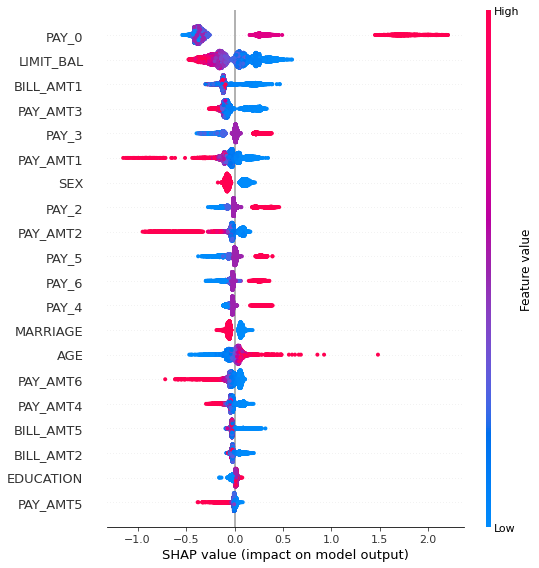

In [47]:
shap.summary_plot(shap_values,x_test) 

Dependence plots help see the relation between a variable and SHAP values. It also shows the intercation feature associated with that variable.

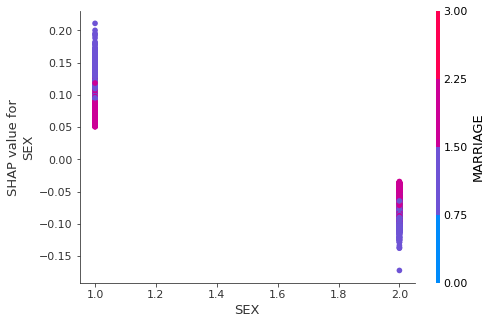

In [58]:
shap.dependence_plot('SEX',shap_values,x_test,dot_size=32)

Force plots, helps us to explain the each prediction and the effect of different features on the output.

In [59]:
#Explain a default client
print(y_test[8])
print(y_proba[8])
row_to_explain=8
shap.force_plot(explainer.expected_value, shap_values[row_to_explain,:], 
                x_test.iloc[row_to_explain,:],link='logit',plot_cmap=["#FF0000","#2E8B57"])

1
0.8337431


In [43]:
#Explain a non-default client.
row_to_explain=1
shap.force_plot(explainer.expected_value, shap_values[row_to_explain,:], 
                x_test.iloc[row_to_explain,:],link='logit',plot_cmap=["#FF0000","#2E8B57"])